In [1]:
import bayes3d as b
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from tqdm import tqdm
import bayes3d.genjax
console = genjax.pretty(show_locals=False)
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import Diff
import inspect

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=20.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

In [5]:
importance_jit = jax.jit(b.genjax.model.importance)

In [6]:
def add_object(trace, key,obj_id, parent, face_parent, face_child):
    N = b.genjax.get_indices(trace).shape[0] + 1
    choices = trace.get_choices()
    choices[f"parent_{N-1}"] = parent
    choices[f"id_{N-1}"] = obj_id
    choices[f"face_parent_{N-1}"] = face_parent
    choices[f"face_child_{N-1}"] = face_child
    choices[f"contact_params_{N-1}"] = jnp.zeros(3)
    return importance_jit(key, choices,
        (jnp.arange(N), jnp.arange(22), *trace.get_args()[2:])
    )[1][1]

add_object_jit = jax.jit(add_object)

In [7]:
contact_enumerators = [b.genjax.make_enumerator([f"contact_params_{i}", "variance", "outlier_prob"]) for i in range(5)]

In [8]:
def c2f_contact_update(trace_, key,  number, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_{number}"]
    scores = contact_enumerators[number][2](trace_, key, contact_param_grid, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
    return contact_enumerators[number][0](
        trace_, key,
        contact_param_grid[i], VARIANCE_GRID[j], OUTLIER_GRID[k]
    )
c2f_contact_update_jit = jax.jit(c2f_contact_update, static_argnames=("number",))

In [71]:
VARIANCE_GRID = jnp.array([0.00001, 0.0001, 0.001])
OUTLIER_GRID = jnp.array([0.01, 0.001, 0.0001])
OUTLIER_VOLUME = 100.0

grid_params = [
    (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi/3, (11,11,11)), (0.05, 0.0, (11,11,1)),
    (0.05, jnp.pi/5, (11,11,11)), (0.02, 2*jnp.pi, (5,5,51))
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]
key = jax.random.PRNGKey(5)

[21 16 20]
-28938.889


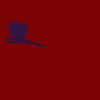

In [96]:
key, (_,gt_trace) = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "parent_2": 0,
    "id_0": jnp.int32(21),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_parent_2": 2,
    "face_child_1": 3,
    "face_child_2": 3,
}), (jnp.arange(3), jnp.arange(22), jnp.ones(3)*100.0, jnp.array([0.2, 0.2, 2*jnp.pi]), b.RENDERER.model_box_dims, 1000.0))
print(b.genjax.get_indices(gt_trace))
print(gt_trace.get_score())
b.genjax.viz_trace_meshcat(gt_trace)

choices = gt_trace.get_choices()
key, (_,trace) = importance_jit(key, choices, (jnp.arange(1), jnp.arange(22), *gt_trace.get_args()[2:]))
b.genjax.viz_trace_meshcat(trace)

b.get_depth_image(gt_trace["image"][...,2])

In [ ]:
all_paths = []
for obj_id in tqdm(range(len(b.RENDERER.meshes)-1)):
    path = []
    trace_ = add_object_jit(trace, key, obj_id, 0, 2,3)
    number = b.genjax.get_contact_params(trace_).shape[0] - 1
    path.append(trace_)
    for c2f_iter in range(len(contact_param_gridding_schedule)):
        trace_ = c2f_contact_update_jit(trace_, key, number,
            contact_param_gridding_schedule[c2f_iter], VARIANCE_GRID, OUTLIER_GRID)
        # trace_ = c2f_contact_update_jit(trace_, key, number,
        #     contact_param_gridding_schedule[c2f_iter], VARIANCE_GRID, OUTLIER_GRID)
        path.append(trace_)
    # for c2f_iter in range(len(contact_param_gridding_schedule)):
    #     trace_ = c2f_contact_update_jit(trace_, key, number,
    #         contact_param_gridding_schedule[c2f_iter], VARIANCE_GRID, OUTLIER_GRID)
    all_paths.append(
        path
    )

scores = jnp.array([t[-1].get_score() for t in all_paths])
print(scores)
normalized_scores = b.utils.normalize_log_scores(scores)
t = all_paths[jnp.argmax(scores)][-1]
b.genjax.viz_trace_meshcat(t)
trace = t

 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 9/21 [00:01<00:02,  5.68it/s]

In [95]:
b.genjax.viz_trace_meshcat(all_paths[0][-1])